# Notebook for Training Model

Importing modules and functions:

Note: always train the model using this notebook:

In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
from src.pipeline import DataPipeline
from src.model import CNN
from src.train import train_and_evaluate, plot_loss_curves

import numpy as np
import torch
import matplotlib.pyplot as plt

## Run data pipeline:

In [ ]:
#Data loading and preprocessing
image_dir = '../data/npy_images'
label_path = '../data/properties/material_property.csv'
batch_size = 32
test_split = 0.1
val_split = 0.1
pipeline = DataPipeline(image_dir, label_path,batch_size, test_split, val_split)
dataloaders = pipeline.load()
train_loader = dataloaders['train']
val_loader = dataloaders['val']

## Training configure:

In [ ]:
# Initialize the model, loss function, and optimizer
sample_input, _ = next(iter(train_loader))
_, c, h, w = sample_input.shape
model = CNN(input_channels=c, input_height=h, input_width=w)
loss = torch.nn.MSELoss()
lr = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr)

## Training:

Epoch 1/10, Train Loss: 1.0068, Val Loss: 1.0361
Epoch 2/10, Train Loss: 1.0016, Val Loss: 1.0365
Epoch 3/10, Train Loss: 1.0002, Val Loss: 1.0359
Epoch 4/10, Train Loss: 1.0000, Val Loss: 1.0359
Epoch 5/10, Train Loss: 1.0000, Val Loss: 1.0358
Epoch 6/10, Train Loss: 1.0000, Val Loss: 1.0358
Epoch 7/10, Train Loss: 1.0000, Val Loss: 1.0358
Epoch 8/10, Train Loss: 1.0000, Val Loss: 1.0359
Epoch 9/10, Train Loss: 1.0001, Val Loss: 1.0358
Epoch 10/10, Train Loss: 1.0001, Val Loss: 1.0358


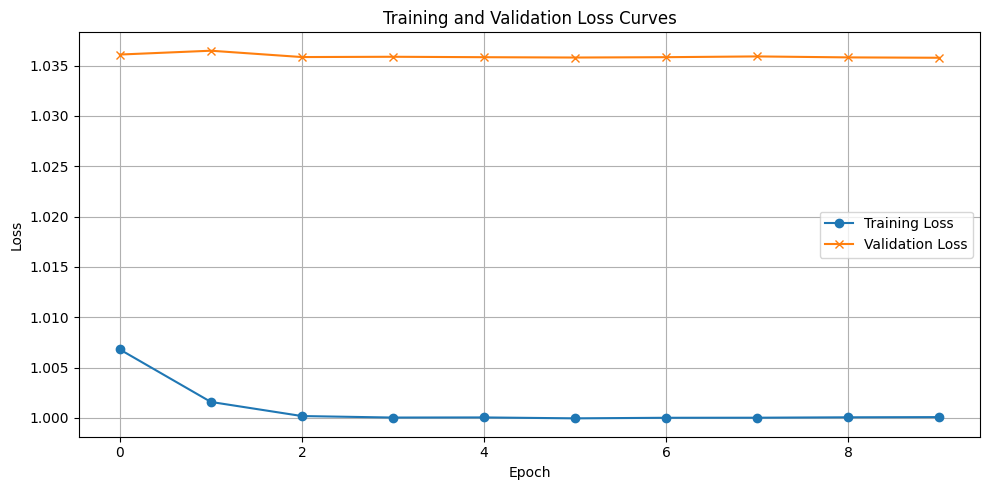

In [3]:
# Train the model
train_losses, val_losses = train_and_evaluate(model, train_loader, val_loader, loss, optimizer, epochs=10)
# Plot training and validation loss curves
plot_loss_curves(train_losses, val_losses)

## Evaluating model for train:

In [ ]:
X_train_list = []
y_train_list = []
for batch_X, batch_y in train_loader:
    X_train_list.append(batch_X)
    y_train_list.append(batch_y)

X_train = torch.cat(X_train_list, dim=0)
y_train = torch.cat(y_train_list, dim=0)

model.eval()
with torch.no_grad():
    outputs = model(X_train[:10])
    print("Sample predictions:\n", outputs.squeeze())
    print("Corresponding targets:\n", y_train[:10].squeeze())

# Denormalize predictions and ground truth
with torch.no_grad():
    predictions = model(X_train.float()).squeeze().numpy()

y_true = y_train.numpy().squeeze()

# Apply inverse normalization using pipeline statistics
predictions = predictions * pipeline.y_std.item() + pipeline.y_mean.item()
y_true = y_true * pipeline.y_std.item() + pipeline.y_mean.item()

# Compute relative error
relative_errors = np.abs(predictions - y_true) / y_true
within_30_percent = relative_errors < 0.30
accuracy_30 = np.mean(within_30_percent)

print(f"Fraction within 30% error: {accuracy_30:.2%}")

# # Plot histogram of relative errors
# plt.figure(figsize=(8, 5))
# plt.hist(relative_errors, bins=50, alpha=0.7)
# plt.axvline(0.30, color='red', linestyle='--', label='30% Threshold')
# plt.xlabel('Relative Error')
# plt.ylabel('Count')
# plt.title('Histogram of Relative Errors')
# plt.legend()
# plt.tight_layout()
# plt.show()

## Evaluating model for validation:

In [ ]:
X_val_list = []
y_val_list = []
for batch_X, batch_y in val_loader:
    X_val_list.append(batch_X)
    y_val_list.append(batch_y)

X_val = torch.cat(X_val_list, dim=0)
y_val = torch.cat(y_val_list, dim=0)

model.eval()
with torch.no_grad():
    outputs = model(X_val[:10])
    print("Sample predictions:\n", outputs.squeeze())
    print("Corresponding targets:\n", y_val[:10].squeeze())

# Denormalize predictions and ground truth
with torch.no_grad():
    predictions = model(X_val.float()).squeeze().numpy()

y_true = y_val.numpy().squeeze()

# Apply inverse normalization using pipeline statistics
predictions = predictions * pipeline.y_std.item() + pipeline.y_mean.item()
y_true = y_true * pipeline.y_std.item() + pipeline.y_mean.item()

# Compute relative error
relative_errors = np.abs(predictions - y_true) / y_true
within_30_percent = relative_errors < 0.30
accuracy_30 = np.mean(within_30_percent)

print(f"Fraction within 30% error: {accuracy_30:.2%}")